In [1]:
from eda_import import *

In [2]:
# def gen_cluster_index(x, window):
# #     Z = linkage(x.reshape(-1, 1), method='centroid')
# #     np.unique(_idx = fnp.unique((Z, window, criterion='distance')
# #     replace the above two lines with, but Z can be used to draw dendrogram
    
# #     dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
# #     plt.show()
#     return fclusterdata(x.reshape(-1, 1), 
#                         window,
#                         criterion='distance',
#                         metric='euclidean',
# #                         method='centroid'
#                         method='single'
#                        )

# def cluster(x, window):
#     x = np.sort(x)
#     cluster_idx = gen_cluster_index(x, window)
#     return dict(zip(x, cluster_idx))

# def _test(x, window):
#     # in Python3 dict.values() returns a view instead of a list
#     # https://docs.python.org/3/library/stdtypes.html#dict-views
#     return np.unique(list(cluster(np.array(x), window).values())).tolist()

# # some test for single-linkage clustering
# assert _test([1, 2, 3], 20) == [1]
# assert _test([1, 2, 3, 4], 20) == [1]
# assert _test([1, 2, 3, 30, 45], 20) == [1, 2]
# assert _test([10, 30, 50], 20) == [1]
# assert _test([10, 31, 50], 20) == [1, 2]
# assert _test([10, 30, 50, 69], 20) == [1]
# assert _test([10, 30, 50, 70], 20) == [1]
# assert _test([10, 30, 50, 71], 20) == [1, 2]
# assert _test([10, 30, 49, 69], 20) == [1]
# assert _test([1, 10, 24, 28], 20) == [1]
# assert _test([25, 26, 30, 34, 35], 20) == [1]
# assert _test([25, 26, 30, 34, 35, 36, 38, 39, 43, 45, 48, 53, 55, 57, 61, 62, 63,
#        66, 67, 68, 73, 74, 80], 20) == [1]
# # # make sure sorting and median works
# assert _test([10, 20, 30, 40, 50], 15) == [1]
# assert _test([50, 10, 30, 20, 40], 15) == [1]


# def select_rep(df):
#     """select a representative clv per cluster"""
#     md = df.clv.mode()
#     if md.shape[0] > 0:
#         return md.median()
#     else:
#         # if no mode is found, then return median
#         return df.clv.median()

# def cluster_clv_sites(df, window):
#     df = df.copy()
#     vals = df.clv.values
#     uniq = df.clv.unique()
#     if uniq.shape[0] > 1: # other exception would be raised
#         clustered = cluster(uniq, window=window)

#         # reassigned clv
# #         df['clv'] = df.clv.replace(clustered)
#         df['cluster_idx'] = df.clv.replace(clustered)
#         _dd = df.groupby('cluster_idx').apply(select_rep).to_dict()
#         df['mclv'] = df.cluster_idx.replace(_dd).astype(np.int64)
        
#         # removing the same cleavage sites
# #         df = df.loc[df[['gene_name', 'clv', 'kleat_fname']].drop_duplicates().index]
#     else:
#         df['cluster_idx'] = 1 # as its own cluster
#         df['mclv'] = uniq[0]
#     return df

# # # test
# # _lele = pdf.groupby('gene_name').get_group('FGF2').copy()
# # clustered = cluster(_lele.clv.unique())
# # _lele['cluster_idx'] = _lele.clv.replace(clustered)
# # _dd = _lele.groupby('cluster_idx').apply(lambda grp: grp.clv.median()).astype(np.int64).to_dict()
# # # assert list(sorted(_dd.values())) == [123816621, 123819379]
# # # assert list(sorted(_dd.values())) == [123816618, 123819379]
# # # assert list(sorted(_dd.values())) == [123816621, 123819379]

In [4]:
from utils.cluster import cluster_clv_sites

In [5]:
def cluster_to_stable(input_df, wsize):
    # This has the same effect with loop and then pd.concat, 
    # so function for apply returns a dataframe is fine

    # hierarchical clustering help reveal local structure, so clustering over all relevant data first.
    # In other words, cluster-then-filter instead of filter-then-cluster
    _df = input_df.copy()
    for i in range(2):
        print('{0} clustering...'.format(i))
        # cluster twice to final results more stable, see the experiment below
        # NOTE: %time magic inside function may mess up with the returned value
        _df = _df.groupby('gene_name').apply(cluster_clv_sites, wsize).reset_index(drop=True)
    return _df

In [6]:
%time adf = pd.read_pickle('./results/all_cba.KLEAT.on-target-cleaned.filtered.pkl')

CPU times: user 561 ms, sys: 16 s, total: 16.5 s
Wall time: 17.1 s


In [7]:
assert adf.shape[0] == 3420253

In [8]:
adf.head(1)

,gene_name,strand,seqname,clv,length_of_tail_in_contig,number_of_bridge_reads,max_bridge_read_tail_length,analysis_id,clv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,aclv,signed_NDA,NDA
1,RTCA,+,chr1,100732476,0,0,0,1d811d54-caa1-41f3-bfc2-400eebdd97ef,100732475,TTTAAA,14,100732435,100732436,100732485,-9,9


In [9]:
print(adf.columns.values.tolist())

['gene_name', 'strand', 'seqname', 'clv', 'length_of_tail_in_contig', 'number_of_bridge_reads', 'max_bridge_read_tail_length', 'analysis_id', 'clv0', 'hexamer', 'hexamer_id', 'hexamer_loc0', 'hexamer_loc', 'aclv', 'signed_NDA', 'NDA']


### Show the distribution is insensitive to SL clustering cutoff

In [10]:
wsizes = [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 50, 75, 100, 200]
sl_clu_dfs = {}
for k, wsize in enumerate(wsizes):
    print('working on wsize: {0}...'.format(wsize), end=', ')
    _df = adf.copy()
    _df = cluster_to_stable(_df, wsize=wsize)
    _df['sdist_mclv2aclv'] = _df['mclv'] - _df['aclv']
    sl_clu_dfs[wsize] = _df

working on wsize: 1..., 0 clustering...
1 clustering...
working on wsize: 2..., 0 clustering...
1 clustering...
working on wsize: 3..., 0 clustering...
1 clustering...
working on wsize: 5..., 0 clustering...
1 clustering...
working on wsize: 10..., 0 clustering...
1 clustering...
working on wsize: 15..., 0 clustering...
1 clustering...
working on wsize: 20..., 0 clustering...
1 clustering...
working on wsize: 25..., 0 clustering...
1 clustering...
working on wsize: 30..., 0 clustering...
1 clustering...
working on wsize: 35..., 0 clustering...
1 clustering...
working on wsize: 50..., 0 clustering...
1 clustering...
working on wsize: 75..., 0 clustering...
1 clustering...
working on wsize: 100..., 0 clustering...
1 clustering...
working on wsize: 200..., 0 clustering...
1 clustering...


In [11]:
for _df in sl_clu_dfs.values():
    _df['sdist_mclv2aclv'] = _df['mclv'] - _df['aclv']

In [12]:
_df.head(1)

,gene_name,strand,seqname,clv,length_of_tail_in_contig,number_of_bridge_reads,max_bridge_read_tail_length,analysis_id,clv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,aclv,signed_NDA,NDA,cluster_idx,mclv,sdist_mclv2aclv
0,ABL1,+,chr9,133763062,11,0,0,1d811d54-caa1-41f3-bfc2-400eebdd97ef,133763061,AATAAA,1,133763038,133763039,133763062,0,0,1,133763062,0


In [13]:
GB_KEYS = ['gene_name', 'seqname', 'strand', 'mclv', 'cluster_idx']

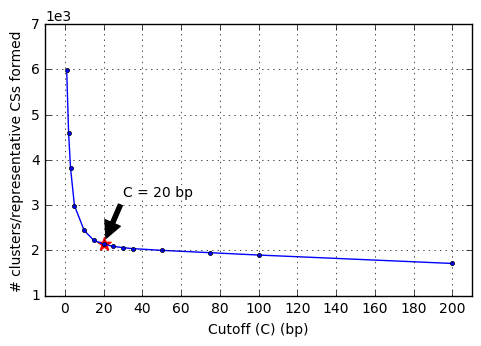

In [14]:
my_cutoff = 20

num_mclvs = []
for k, wsize in enumerate(wsizes):
    num_mclvs.append(sl_clu_dfs[wsize].mclv.unique().shape[0])

fig = plt.figure(figsize=(5.5, 3.5))
ax = fig.add_subplot(111)

ax.plot(wsizes, num_mclvs, marker='o', ms=3)
idx = wsizes.index(my_cutoff)
ax.scatter([my_cutoff], [num_mclvs[idx]], marker='*', color='red', s=100, alpha=1)
ax.annotate('C = 20 bp', xy=(my_cutoff, num_mclvs[idx]), xytext=(30, 3200),
            arrowprops=dict(facecolor='black', shrink=0.13, width=3),
            bbox=dict(pad=0, fc='white', ec='none'),
            )
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xlim([-10, 210])
ax.set_xlabel('Cutoff (C) (bp)')
ax.set_ylabel('# clusters/representative CSs formed')
ax.set_xticks(np.arange(0, 201, 20))
ax.grid()

1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 50, 75, 100, 200, 

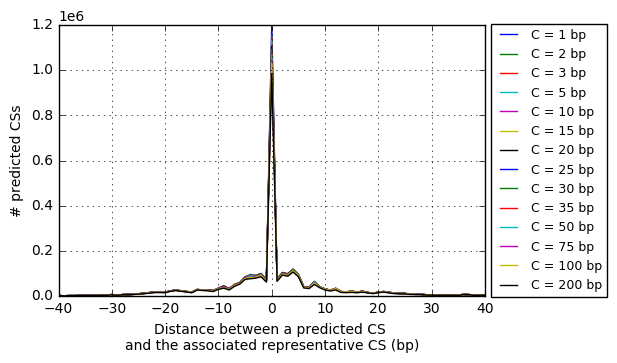

In [17]:
colors = mpl.cm.jet(np.linspace(0, 1, len(wsizes)))
fig = plt.figure(figsize=(5.5, 3.5))
ax = fig.add_subplot(111)
for k, wsize in enumerate(wsizes):
    print('{0}'.format(wsize), end=', ')
    label = 'C = {0} bp'.format(wsize)
    _df = sl_clu_dfs[wsize]
    (_df['clv'] - _df['mclv']).value_counts().sort_index().plot(ax=ax, lw=1, label=label)

ax.set_xlim(-40, 40)
ax.set_xlabel('Distance between a predicted CS \nand the associated representative CS (bp)')
ax.set_ylabel('# predicted CSs')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1, 1.028), fontsize=9)
# plt.savefig('./results/figs/hist-CS-ranges-by-clustering-cutoff.png', 
#             dpi=200)

1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 50, 75, 100, 200, 

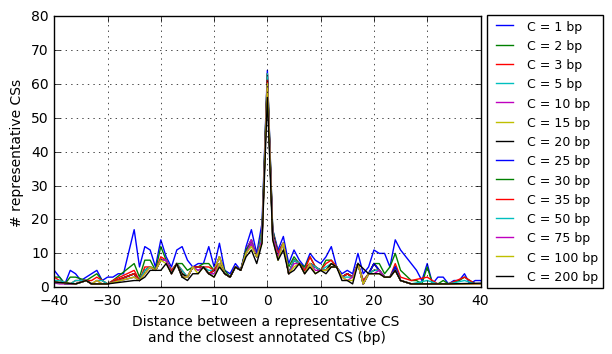

In [18]:
colors = mpl.cm.jet(np.linspace(0, 1, len(wsizes)))
fig = plt.figure(figsize=(5.5, 3.5))
ax = fig.add_subplot(111)
for k, wsize in enumerate(wsizes):
    print('{0}'.format(wsize), end=', ')
    label = 'C = {0} bp'.format(wsize)
    _df = sl_clu_dfs[wsize]
    _df = _df[['seqname', 'strand', 'mclv', 'aclv']].drop_duplicates()
    (_df['mclv'] - _df['aclv']).value_counts().sort_index().plot(ax=ax, lw=1, label=label)

ax.set_xlim(-40, 40)
ax.set_ylim(0, 80)
ax.set_xlabel('Distance between a representative CS \nand the closest annotated CS (bp)')
ax.set_ylabel('# representative CSs')
ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1, 1.028), fontsize=9)
# plt.savefig('results/figs/hist-CS-ranges-by-clustering-cutoff.png', 
#             dpi=200)